Fine tunes an object detection model to detect text in signboard images

In [0]:
from google.colab import drive
drive.mount('/content/drive' ,force_remount=True)

Mounted at /content/drive


In [0]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tarfile
import torch

from ast import literal_eval
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [0]:
tar_file_path = '/content/drive/My Drive/Project STation/OD/detection.tar'

with tarfile.open(tar_file_path, 'r') as tarfile:
    tarfile.extractall('detection/')

In [0]:
annotation_file_path = '/content/drive/My Drive/Project STation/OD/annotations.csv'
image_file_path = '/content/detection/real_Image_dataset_Detection/Image'

In [0]:
gt = pd.read_csv(annotation_file_path).set_index('image')
gt.head()

,coords,height,width,c_coords,label
image,,,,,
detection/real_Image_dataset_Detection/Image/129.jpg,"[(286, 683, 683, 286, 25, 25, 204, 204), (268,...","[179, 155, 110]","[397, 412, 402]","[[484.5, 114.5], [474.0, 271.5], [460.0, 404.0]]","['HINDI', 'HINDI', 'HINDI']"
detection/real_Image_dataset_Detection/Image/317.jpg,"[(59, 157, 157, 59, 201, 201, 261, 261), (159,...","[60, 74, 73, 85, 39, 47, 49, 57, 49]","[98, 169, 149, 167, 185, 175, 134, 54, 31]","[[108.0, 231.0], [243.5, 222.0], [407.5, 218.5...","['HINDI', 'HINDI', 'HINDI', 'HINDI', 'HINDI', ..."
detection/real_Image_dataset_Detection/Image/124.jpg,"[(5, 272, 272, 5, 183, 183, 400, 400), (257, 4...","[217, 196, 225]","[267, 175, 277]","[[138.5, 291.5], [344.5, 245.0], [571.5, 286.5]]","['HINDI', 'HINDI', 'HINDI']"
detection/real_Image_dataset_Detection/Image/153.jpg,"[(240, 310, 310, 240, 28, 28, 70, 70), (304, 3...","[42, 56, 46, 172, 137, 96]","[70, 50, 64, 273, 198, 167]","[[275.0, 49.0], [329.0, 50.0], [389.0, 49.0], ...","['HINDI', 'HINDI', 'HINDI', 'HINDI', 'HINDI', ..."
detection/real_Image_dataset_Detection/Image/28.jpg,"[(321, 487, 487, 321, 160, 160, 203, 203), (42...","[43, 70, 65, 80, 48, 46, 41, 34, 38, 46]","[166, 190, 160, 208, 73, 54, 107, 72, 59, 143]","[[404.0, 181.5], [137.0, 253.0], [310.0, 236.5...","['HINDI', 'HINDI', 'HINDI', 'HINDI', 'HINDI', ..."


In [0]:
# Sanity check the bounding boxes in the images
def plot_bounding_boxes(image, boxes, color='r'):
    if color == 'r':
        code = (255, 0, 0)
    elif color == 'b':
        code = (0, 0, 255)
    elif color == 'g':
        code = (0, 255, 0)
    else:
        raise ValueError(f'Color :{color} is not supported yet')

    if isinstance(image, torch.Tensor):
        img = image.permute(1, 2, 0).numpy()
    else:
        img = image
    img2 = img.copy()
    for box in boxes:
        if isinstance(box, torch.Tensor):
            box = box.numpy()
        tl = tuple(box[:2])
        br = tuple(box[2:])
        cv2.rectangle(img2, tl, br, code, 3)
    return img2

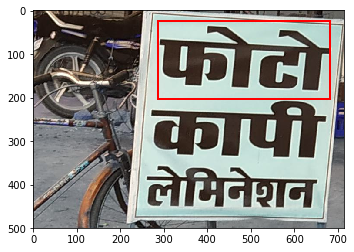

In [0]:
base_dir = '/content'
img_rel_path = 'detection/real_Image_dataset_Detection/Image/129.jpg'
img_path = os.path.join(base_dir, img_rel_path)
img = cv2.imread(img_path)
bboxes = [(286, 25, 683, 204)]
img = plot_bounding_boxes(img, bboxes)
plt.imshow(img)

## Dataset Creation

1) Create a dataset for finetuning the Faster-RCNN model

In [0]:
# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git

!cp vision/references/detection/utils.py .
!cp vision/references/detection/transforms.py .
!cp vision/references/detection/coco_eval.py .
!cp vision/references/detection/engine.py .
!cp vision/references/detection/coco_utils.py .

Cloning into 'vision'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 4779 (delta 9), reused 4 (delta 2), pack-reused 4750
Receiving objects: 100% (4779/4779), 9.12 MiB | 17.58 MiB/s, done.
Resolving deltas: 100% (3110/3110), done.


In [0]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
class SignboardDataset(Dataset):

    def __init__(self, image_path, annotation_file_path, transform=None, device=None):
        self.ground_truth = pd.read_csv(annotation_file_path).set_index('image')
        self.transform = transform
        self.device = torch.device('cpu')
        if device is not None:
            self.device = device

    def __len__(self):
         return len(self.ground_truth)
    
    def __getitem__(self, idx):
        img_path = self.ground_truth.iloc[idx].name
        # get the bounding box annotations for this image
        bb_info = self.ground_truth.loc[img_path]
        image = cv2.imread(img_path)

        target = {}
        num_boxes = len(literal_eval(bb_info['coords']))
        boxes = [[box[0], box[4], box[2], box[6]] for box in literal_eval(bb_info['coords'])]
        target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
        # There is only a single label for `HINDI`
        target['labels'] = torch.ones((num_boxes,), dtype=torch.int64)
        target['image_id'] = torch.tensor([idx])
        target['area'] = torch.Tensor([height * width for height, width in 
                                       zip(literal_eval(bb_info['height']), literal_eval(bb_info['width']))])
        target['iscrowd'] = torch.zeros((num_boxes,), dtype=torch.int64)

        if self.transform is not None:
            image, target = self.transform(image, target)
        return image, target

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'boxes': tensor([[200., 136., 407., 217.],
        [410., 137., 536., 218.],
        [538., 136., 690., 234.]]), 'labels': tensor([1, 1, 1]), 'image_id': tensor([305]), 'area': tensor([16767., 10206., 14896.]), 'iscrowd': tensor([0, 0, 0])}


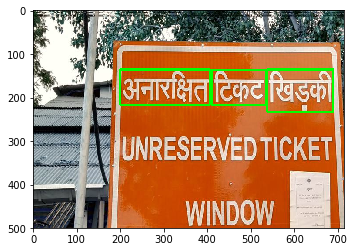

In [0]:
# Sanity check the dataset output
dataset = SignboardDataset(image_file_path, annotation_file_path, transform=get_transform(train=True))
sample_image, sample_target = dataset[305]
print(sample_target)
plt.imshow(sample_image.permute(1, 2, 0))
img = plot_bounding_boxes(sample_image, sample_target['boxes'], color='g')
plt.imshow(img)

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import evaluate, train_one_epoch
import utils

In [0]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
dataset = SignboardDataset(image_file_path, annotation_file_path, transform=get_transform(train=True), device=device)
dataset_test = SignboardDataset(image_file_path, annotation_file_path, transform=get_transform(train=False), device=device)

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

cuda


In [0]:
# Sanity check forward pass through the model
sample_img_batch, sample_target_batch = iter(data_loader).next()
img_batch = [img.to(device) for img in sample_img_batch]
target_batch = [{k: v.to(device) for k, v in t.items()} for t in list(sample_target_batch)]
output = model(img_batch, target_batch)
print(output)

{'loss_classifier': tensor(0.4493, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0845, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.2177, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0349, device='cuda:0', grad_fn=<DivBackward0>)}


In [0]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # Training mode
    # model.train()
    # for idx, (input_batch, target_batch) in enumerate(data_loader):
    #     # Transfer the image batch and targets to the device
    #     img_batch = [img.to(device) for img in input_batch]
    #     target_batch = [{k: v.to(device) for k, v in t.items()} for t in list(target_batch)]
    #     loss_dict = model(img_batch, target_batch)
    #     aggregate_loss = sum([loss for loss in loss_dict.values()])
    #     # Clear the gradients, compute gradients and optimize weights
    #     optimizer.zero_grad()
    #     aggregate_loss.backward()
    #     optimizer.step()
    lr_scheduler.step()

    #     if idx % 10 == 0:
    #         print(f'Epoch: {epoch + 1} Data steps: {idx + 1} Aggregate Loss: {aggregate_loss.item()}')
    evaluate(model, data_loader_test, device=device)

In [0]:
# Save the model
model_name = 'FasterRCNN'
backbone = 'resnet50-FPN'
augmentation_details = 'hf0_5'
model_file_name = f'{model_name}__{backbone}__{num_epochs}__{augmentation_details}.pt'
torch.save(model.state_dict(), model_file_name)

In [0]:
# Load the model and get predictions
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load('/content/drive/My Drive/Project STation/OD/results/FasterRCNN__resnet50-FPN__10__hf0_5.pt'))

test_dataset = SignboardDataset(image_file_path, annotation_file_path, transform=get_transform(train=False), device=device)
test_image, _ = test_dataset[200]

In [0]:
import time
model.eval()
starttime = time.time()
with torch.no_grad():
    model.to(device)
    predictions = model([test_image.to(device)])
finaltime = time.time()

print(f'Time for predictions: {finaltime - starttime}')

Time for predictions: 0.5064883232116699


In [0]:
predictions

[{'boxes': tensor([[ 67.3209, 164.3583, 704.8158, 376.2827],
          [  0.0000,  76.4924, 178.8621, 235.3283],
          [ 92.8880, 173.7089, 404.6051, 352.8683],
          [396.3815, 165.9653, 696.1828, 379.9417],
          [  0.0000, 109.3874, 102.0842, 235.2894],
          [507.7963, 101.1761, 696.1176, 169.3885]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9977, 0.9187, 0.6969, 0.2484, 0.1714, 0.0505], device='cuda:0')}]

In [0]:
gt_image = test_image
gt_shape = gt_image.shape
boxes = sample_target['boxes'].numpy()

predicted_boxes = predictions[0]['boxes'].detach().cpu().numpy()
final_boxes = list()
thresh = 0.9
for idx, box in enumerate(predicted_boxes):
    if predictions[0]['scores'].detach().cpu().numpy()[idx] > thresh:
        final_boxes.append(box)
print(predicted_boxes.shape)
pred_img = plot_bounding_boxes(gt_image.cpu(), final_boxes)

plt.imshow(pred_img)

TypeError: ignored

{'area': tensor([71063., 63860., 44220.]),
 'boxes': tensor([[286.,  25., 683., 204.],
         [268., 194., 680., 349.],
         [259., 349., 661., 459.]]),
 'image_id': tensor([0]),
 'iscrowd': tensor([0, 0, 0]),
 'labels': tensor([1, 1, 1])}